<a href="https://colab.research.google.com/github/Igor-Belskiy/rbk-case/blob/main/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%91%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np   # для работы с данными
import pandas as pd   # для работы с таблицами
import time    # Импортируем библиотеку time
from datetime import datetime    # Для обработки дат
import re

import matplotlib.pyplot as plt #Отрисовка графиков

from tensorflow.keras.preprocessing.text import Tokenizer   # Методы для работы с текстами и преоборазвания их в последовательности
from tensorflow.keras import utils  # для работы с категориальными данными
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from tensorflow.keras.utils import plot_model     # Для отрисовки моделей

from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from sklearn.model_selection import train_test_split  # Для раздения выборки на тестовую и обучающую

# Загрузка данных

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd   # для загрузки с гугл-драйва в колабораторию

# Копию бучающег и тестовог датасета предварительно загрузил к себе на гугл-диск
# и Колабораторию загружаю их напрямую уже со своего диска (досутуп отркыт для всех по ссылке)

gdd.download_file_from_google_drive(file_id='1OJs8ZLeKe1BflJMGWM5QLbsbMHCiWhJ7', 
                                    dest_path='/content/test_dataset_test.csv', 
                                    showsize=True,
                                    overwrite=True) #Скачиваем тестовый датасет

gdd.download_file_from_google_drive(file_id='1sIbebBPuT3YC6OC-uUP8Q7i3YUJfS2Ad', 
                                    dest_path='/content/train_dataset_train.csv', 
                                    showsize=True,
                                    overwrite=True) #Скачиваем тренировочный датасет

1.2 MiB Done.
2.9 MiB Done.


In [3]:
df_test = pd.read_csv('/content/test_dataset_test.csv', index_col= 0)

df_train = pd.read_csv('/content/train_dataset_train.csv', index_col= 0)

In [4]:
df_train.columns

Index(['title', 'publish_date', 'session', 'authors', 'ctr', 'category',
       'tags', 'views', 'depth', 'full_reads_percent'],
      dtype='object')

In [5]:
df_train.shape[0]

7000

# Предварительный осмотр данных

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ to 627f1c089a794743b070ff73hVvdVmFxS2SlZ2_lECDEow
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               7000 non-null   object 
 1   publish_date        7000 non-null   object 
 2   session             7000 non-null   object 
 3   authors             7000 non-null   object 
 4   ctr                 7000 non-null   float64
 5   category            7000 non-null   object 
 6   tags                7000 non-null   object 
 7   views               7000 non-null   int64  
 8   depth               7000 non-null   float64
 9   full_reads_percent  7000 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 601.6+ KB


In [7]:
df_train.head()

,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent
document_id,,,,,,,,,,
624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,IDE7mtH4RBqGn-8MXfGffQ,[],1.580,5409f11ce063da9c8b588a18,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,35.850
620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,KtVJsteHStO5oditt3Uvzw,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,5409f11ce063da9c8b588a12,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,38.355
620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,hk7puWJwSziw0m3sfTkKWA,[],0.000,5409f11ce063da9c8b588a12,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,36.424
6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,7UKY2SSZTjCcjhwBzxw37w,[],0.000,5409f11ce063da9c8b588a12,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,30.169
626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,wuMYES90REuV5YhrN75IXg,[],0.000,5433e5decbb20f277b20eca9,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,34.617


In [8]:
df_test.head()

,title,publish_date,session,authors,ctr,category,tags
document_id,,,,,,,
61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,«Крайне провокационная тема»: как Россия и США...,2022-02-01 17:02:44,J0AvX96vTAaQCiWVbzoMdw,[],0.000,5409f11ce063da9c8b588a12,"['58ca77679a794700b1e37f0a', '5409f1b7e063daa0..."
628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,Власти Херсонской области пообещали сделать ру...,2022-05-24 00:50:55,QS5CqzXYRnmDdR2LaSreEw,[],1.598,5409f11ce063da9c8b588a12,"['5433603acbb20f6e5def0cc5', '5409f420e063daa0..."
627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,Премьер и президент Финляндии призвали срочно ...,2022-05-12 07:11:51,XVsoyrUOT8OJJg2_finJhw,[],2.006,5409f11ce063da9c8b588a12,"['5409f270e063daa0f408b0a7', '5409f196e063daa0..."
628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,В Госдуму внесли проект о временных администра...,2022-05-19 11:54:35,upfii3whSSuMXCqcqF8VbQ,[],0.000,5409f11ce063da9c8b588a12,"['5409f145e063daa0f408ad35', '5409f30fe063daa0..."
620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,Блинкен заявил в ООН о готовности России начат...,2022-02-17 16:28:55,5hzCiIHdSYKQIr8WAM18bw,['604f2c199a79478ec0029eae'],9.136,5409f11ce063da9c8b588a12,"['5409f15de063daa0f408ada8', '545d4dcdcbb20fbc..."


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw to 6236f9129a79477b0ef18ae0ewByZQ1FQBK2dpXyY77rYw
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3000 non-null   object 
 1   publish_date  3000 non-null   object 
 2   session       3000 non-null   object 
 3   authors       3000 non-null   object 
 4   ctr           3000 non-null   float64
 5   category      3000 non-null   object 
 6   tags          3000 non-null   object 
dtypes: float64(1), object(6)
memory usage: 187.5+ KB


In [10]:
# Смотрим, сколько каких значений в столбцах

for x in df_train.columns:
    print('Столбец: ', x)
    print(df_train[x].value_counts())
    print('\n')

Столбец:  title
Какие места на Украине взяли под контроль российские военные. Карта                                                                                                                10
Как менялась ключевая ставка ЦБ за последние годы. Инфографика                                                                                                                      7
Как Запад и Россия поставили рекорд по высылкам дипломатов. Инфографика                                                                                                             6
Какие приграничные пункты попали под обстрел со стороны Украины. Карта                                                                                                              5
Какие регионы объявили высокий уровень террористической опасности. Карта                                                                                                            4
                                                                          

In [11]:
df_train['title'].value_counts()

Какие места на Украине взяли под контроль российские военные. Карта                                                                                                                10
Как менялась ключевая ставка ЦБ за последние годы. Инфографика                                                                                                                      7
Как Запад и Россия поставили рекорд по высылкам дипломатов. Инфографика                                                                                                             6
Какие приграничные пункты попали под обстрел со стороны Украины. Карта                                                                                                              5
Какие регионы объявили высокий уровень террористической опасности. Карта                                                                                                            4
                                                                                          

In [12]:
for i in df_train.columns :  
  print(f'Колонка "{i}": \nУникальныех значении: {df_train[i].nunique()} \n {df_train[i].unique()}\n\n') 

Колонка "title": 
Уникальныех значении: 6954 
 ['Европейский банк развития приостановил доступ Москвы и Минска к финансам'
 'Кремль назвал регулярным процессом учебные запуски баллистических ракет'
 'Госсекретарь Швеции заявила о нежелании вступать в НАТО из-за Украины\n                \n                                                    \n\n    \n\n    Политика,\xa007:24'
 ... 'Брюс Уиллис завершит актерскую карьеру из-за болезни'
 'Экс-посол Франции назвал болезненным для Европы отказ от российской нефти\n                \n                                                    \n\n    \n\n    Экономика,\xa002:15'
 'Минфин США предостерег зарубежные банки от помощи России в обходе санкций']


Колонка "publish_date": 
Уникальныех значении: 6985 
 ['2022-04-04 10:29:44' '2022-02-18 10:00:39' '2022-02-12 04:24:02' ...
 '2022-03-30 21:59:02' '2022-05-04 23:15:48' '2022-05-14 03:41:33']


Колонка "session": 
Уникальныех значении: 5901 
 ['IDE7mtH4RBqGn-8MXfGffQ' 'KtVJsteHStO5oditt3Uvzw'
 'hk

# Готовим входную колонку title методом Bag of Words

In [13]:

maxWordsCount = 1000   # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, 
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', 
                      lower=True, 
                      split=' ', 
                      oov_token='unknown', 
                      char_level=False)


In [14]:
# Перед обучением частотного словаря удаляем из него отметки минут в тексте некоторых заголовков.
# Так как стандартный фильтр токенайзера их не удаляет

titles_for_tokenizer = [re.sub(r"\d{2}:\d{2}", " ", df_train['title'][x]) for x in range(df_train.shape[0])]

In [15]:

tokenizer.fit_on_texts(titles_for_tokenizer) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра (по сути, это словарь частотности слов)


In [16]:
items[:20]      # Смотрим 20 самых популярных слов частотного словаря

[('unknown', 1),
 ('в', 2),
 ('о', 3),
 ('политика', 4),
 ('на', 5),
 ('и', 6),
 ('с', 7),
 ('россии', 8),
 ('общество', 9),
 ('из', 10),
 ('за', 11),
 ('по', 12),
 ('заявил', 13),
 ('об', 14),
 ('сша', 15),
 ('украине', 16),
 ('что', 17),
 ('для', 18),
 ('украины', 19),
 ('не', 20)]

In [17]:
len(items)    # Количество слов в частотном словаре токенайзера

14465

In [18]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю

train_title = []

train_title = tokenizer.texts_to_sequences(df_train['title'])

In [19]:
# Осматриваем результаты полученных промежуточных преоборазовании

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", df_train['title'][10])
print("Он же в виде последовательности индексов: ", train_title[10], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Медведев обвинил Зеленского в выдвижении «невыполнимых ультиматумов»
Он же в виде последовательности индексов:  [100, 137, 126, 2, 1, 1, 1] 



In [20]:
len(train_title)

7000

In [21]:
type(train_title)

list

In [22]:
xTrain_title = tokenizer.sequences_to_matrix(train_title)   #Делаем вектора Bag of words 

In [23]:
xTrain_title.shape

(7000, 1000)

# Готовим выходный данные для обучения

## Обрабатываем стобец "views"

In [24]:
df_train['views'].sort_values()

document_id
6236462b9a7947544365254d0664WRQsQRGOIbsqUT0LSw         65
62041eec9a79471dce8208efxEswFOOoQfCF4N1Bk-LgTA         84
6246149a9a79471201b16ca0Lm-NghnfRxGWgbUqr5JFKQ        151
6236a0269a794766048156dff0UsY8pGTL6Q22boUeuU6w        165
626d98eb9a794774ea27e974WDK4DyQ7T5aV1ltVQNkAGg        181
                                                   ...   
62074b119a7947b0e49b36f7ogeueMGYROCLw1nvmiGQrw    2554204
62074b119a7947b0e49b36f7LcIC7Zi9RVaJjBx5VlFp3w    2554204
62074b119a7947b0e49b36f7yeqcRbtLQuCcsxUjWqbUFg    2554204
62074b119a7947b0e49b36f73kkiEgVVT3qV3E7Hd2cDsg    2554204
62074b119a7947b0e49b36f7iNdNbeY3TLyxxJmCeU8LdA    2554204
Name: views, Length: 7000, dtype: int64

In [25]:
yTrain_views = np.array(df_train['views']).reshape(-1, 1)    # Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.

yTrain_views.shape

(7000, 1)

In [26]:
yViewsScaler = StandardScaler()

yViewsScaler.fit(yTrain_views)       # Тренируем нормировщик на выходных данных views

yTrain_views_Scalered = yViewsScaler.transform(yTrain_views)     # Переводим данные views в нормированную форму с помощью нормировщика

In [27]:
yTrain_views_Scalered.shape

(7000, 1)

## Обрабатываем столбец "depth"

In [28]:
df_train['depth'].sort_values()

document_id
62931bae9a7947448b3cdab4SRPnZWHSRFmlCCZwce5APg    1.016
626a67e19a7947694894d707EcrLAABxS86ihA553FEnAA    1.020
62614a2f9a79479125d98653PUY3qhYWRGSMnqBumpqeiw    1.020
62611dec9a794779e452cfb1Hle9FXT6Sh6us8D8OrseOQ    1.021
62866e759a7947002d54b2be01aClYwET-29ZVkjDNZBHg    1.021
                                                  ...  
62074b119a7947b0e49b36f72XRjXJ3MR0qlf6Jx-rIRbg    1.799
62074b119a7947b0e49b36f7yeqcRbtLQuCcsxUjWqbUFg    1.799
62074b119a7947b0e49b36f73kkiEgVVT3qV3E7Hd2cDsg    1.799
62074b119a7947b0e49b36f7LcIC7Zi9RVaJjBx5VlFp3w    1.799
62074b119a7947b0e49b36f7ogeueMGYROCLw1nvmiGQrw    1.799
Name: depth, Length: 7000, dtype: float64

In [29]:
# Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.
yTrain_depth = np.array(df_train['depth']).reshape(-1, 1)    
yTrain_depth.shape

(7000, 1)

In [30]:
yDepthScaler = StandardScaler()

yDepthScaler.fit(yTrain_depth)       # Тренируем нормировщик на выходных данных depth

yTrain_depth_Scalered = yDepthScaler.transform(yTrain_depth)     # Переводим данные views в нормированную форму с помощью нормировщика

In [31]:
yTrain_depth_Scalered.shape

(7000, 1)

## Обрабатываем столбец "full_reads_percent"

In [32]:
df_train['full_reads_percent'].sort_values()

document_id
62074b119a7947b0e49b36f7iNdNbeY3TLyxxJmCeU8LdA      4.978
62074b119a7947b0e49b36f72XRjXJ3MR0qlf6Jx-rIRbg      4.978
62074b119a7947b0e49b36f7yeqcRbtLQuCcsxUjWqbUFg      4.978
62074b119a7947b0e49b36f7LcIC7Zi9RVaJjBx5VlFp3w      4.978
62074b119a7947b0e49b36f7ogeueMGYROCLw1nvmiGQrw      4.978
                                                   ...   
623abb1b9a794723857a6b38asdbqAtwSniZn6glDcdeaw     66.821
623aee679a79473f14281240Dd2iw8x3QwyFsxwT7qsyTQ     67.897
62366acc9a79475cac43e970La4nBiKdRjq-HPcQ4-YKBg     75.729
6271d52c9a7947d7db0ac981ciz7jAbTRRGPTfRmXmajDA    217.550
620493199a794737f29908f0wCy2KZoJSJiKDhPixqcYZg    267.623
Name: full_reads_percent, Length: 7000, dtype: float64

In [33]:
# Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.
yTrain_reads = np.array(df_train['full_reads_percent']).reshape(-1, 1)    
yTrain_reads.shape

(7000, 1)

In [34]:
yReadsScaler = StandardScaler()

yReadsScaler.fit(yTrain_reads)       # Тренируем нормировщик на выходных данных depth

yTrain_reads_Scalered = yReadsScaler.transform(yTrain_reads)     # Переводим данные views в нормированную форму с помощью нормировщика

In [35]:
yTrain_reads_Scalered.shape

(7000, 1)

## Объединяем целевые столбцы views, depth и full_reads_percent в один массив

In [36]:
yTrainScalered = np.concatenate ( (yTrain_views_Scalered, yTrain_depth_Scalered, yTrain_reads_Scalered), axis=1)

yTrainScalered.shape

(7000, 3)

In [37]:
print(yTrainScalered[0], yTrain_views_Scalered[0], yTrain_depth_Scalered[0], yTrain_reads_Scalered[0])

[-0.10360856  0.44922444  0.11418581] [-0.10360856] [0.44922444] [0.11418581]


# Делаем первую сеть для прогнозирования с одним входом "title" и нормированным выходом

In [38]:
#Создаём нейронку
model_1 = Sequential()
model_1.add(Dense(200, input_dim=1000, activation="relu"))
#model_1.add(BatchNormalization())
model_1.add(Dense(200, activation="relu"))
model_1.add(Dense(200, activation="relu"))
model_1.add(Dense(3, activation='relu'))


In [39]:

model_1.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='mae', 
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               200200    
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 3)                 603       
                                                                 
Total params: 281,203
Trainable params: 281,203
Non-trainable params: 0
_________________________________________________________________


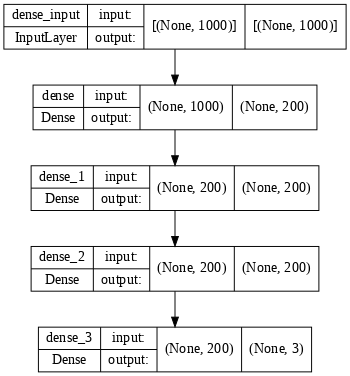

In [40]:
model_1.summary()
plot_model(model_1, dpi=70, show_shapes=True)

In [41]:
# test_size=0.2 - будет выделено 20% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train, y_test = train_test_split(xTrain_title, yTrainScalered, test_size=0.2, shuffle=True)

In [42]:
y_train[1]

array([ 0.15258431, -0.21217527, -0.12228464])

In [43]:
x_train[833].sum()

4.0

In [44]:
history = model_1.fit(x_train, 
                      y_train, 
                      epochs=5,
                      batch_size=20,
                      validation_data=(x_test, y_test))

Epoch 1/5
280/280 [==============================] - 8s 8ms/step - loss: 0.6184 - accuracy: 0.3862 - val_loss: 0.6128 - val_accuracy: 0.4193
Epoch 2/5
280/280 [==============================] - 2s 6ms/step - loss: 0.6059 - accuracy: 0.4609 - val_loss: 0.6077 - val_accuracy: 0.4279
Epoch 3/5
280/280 [==============================] - 1s 5ms/step - loss: 0.5945 - accuracy: 0.4921 - val_loss: 0.6035 - val_accuracy: 0.4650
Epoch 4/5
280/280 [==============================] - 1s 5ms/step - loss: 0.5804 - accuracy: 0.5161 - val_loss: 0.6018 - val_accuracy: 0.4764
Epoch 5/5
280/280 [==============================] - 1s 5ms/step - loss: 0.5652 - accuracy: 0.5555 - val_loss: 0.6010 - val_accuracy: 0.4864


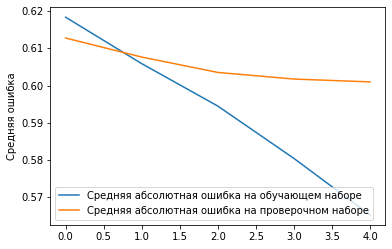

In [45]:
#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

# Готовим цифровые входные данные

# Столбец "publish_date"

In [46]:
df_train['publish_date'].sort_values()

document_id
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A    2017-08-07 13:00:27
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A    2018-02-22 14:28:30
605321259a7947663a3b6ab2vgBnAMPBRIOYrUrK0JeEiQ    2021-04-12 11:01:26
609d47119a794795c5f7617dh5z7vG_TQAu5Q7Nwp35LUw    2021-05-14 11:19:24
5afd8e7f9a794772862de199oXkM3UjQQRK7NZTlmVi63A    2021-05-17 14:40:01
                                                         ...         
6293bcc69a79476bca4de7e06uBhesj2TgOK5SlFSHaWiQ    2022-05-29 19:06:09
6293a1b69a7947653ffd66efFYhaM6abQJOYhQqxvb41jg    2022-05-29 19:18:23
6293c7a19a79476e99870dd7VCw7wJgfTKyFEL4JwVcXSQ    2022-05-29 19:29:36
62931bae9a7947448b3cdab4SRPnZWHSRFmlCCZwce5APg    2022-05-29 20:02:22
6293d0179a79477232e448779KjDybk2Qvmz5zQcrJ1S-Q    2022-05-29 20:13:12
Name: publish_date, Length: 7000, dtype: object

In [47]:
# Достаём из даты публикации отдельно месяц, день, час, минуту и день недели.

Train_Publish_Date=[]

for x in range(df_train['publish_date'].shape[0]):
  d = datetime.strptime(df_train['publish_date'][x], '%Y-%m-%d %H:%M:%S')   # Получаем из строки объект типа datetime_object
  Train_Publish_Date.append([d.month, d.day, d.hour, d.minute, d.weekday()])

In [48]:
Train_Publish_Date = np.array(Train_Publish_Date)     # Трансформируем в массив типа numpy

In [49]:
Train_Publish_Date.shape

(7000, 5)

In [78]:
# Нормируем дынные о дате публикации. Для каждой цифры делаем свой MinMaxScaller

Scaler_List = []                   # Список для сохранения объектов нормировщика
Scalered_Train_Publish_Date = []   # Список для сохранения нормированных данных

for x in range(Train_Publish_Date.shape[1]):

    Current_DataForScaler =  Train_Publish_Date.T[x].reshape(-1, 1)    # Готовим данные для подачи в нормировщик
    Current_Scaler = MinMaxScaler()                                    # Создаём новый нормировщик
    Current_Scaler.fit(Current_DataForScaler)                          # Тренируем нормировщик
    Scaler_List.append(Current_Scaler)                                 # Сохраняем обученный нормировщик в список
    Curren_Scalered_Data = Current_Scaler.transform(Current_DataForScaler)       # Нормируем данные
    Scalered_Train_Publish_Date.append(Curren_Scalered_Data)

In [79]:
 # Преобразуем данные в формат numpy и придаём данным нужную форму
Scalered_Train_Publish_Date = np.array(Scalered_Train_Publish_Date).T[0]  

In [80]:
Scalered_Train_Publish_Date.shape

(7000, 5)

In [82]:
Scalered_Train_Publish_Date[0]

array([0.27272727, 0.1       , 0.43478261, 0.49152542, 0.        ])

# Готовим сеть с полноценным выходом (все 3 целевых столбца) и информацией о дате на входе.

In [92]:
#Создаём нейронку
model_2 = Sequential()
model_2.add(Dense(250, input_dim=5, activation="relu"))
model_2.add(Dense(50, activation="relu"))
model_2.add(Dense(3, activation='sigmoid'))

In [102]:
model_2.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='mae', 
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 250)               1500      
                                                                 
 dense_11 (Dense)            (None, 50)                12550     
                                                                 
 dense_12 (Dense)            (None, 3)                 153       
                                                                 
Total params: 14,203
Trainable params: 14,203
Non-trainable params: 0
_________________________________________________________________


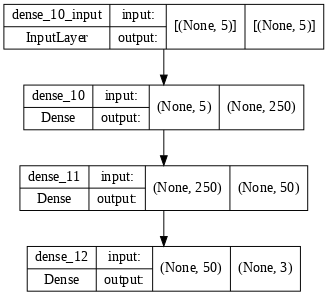

In [94]:
model_2.summary()
plot_model(model_2, dpi=70, show_shapes=True)

In [95]:
# test_size=0.2 - будет выделено 20% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train, y_test = train_test_split(Scalered_Train_Publish_Date, yTrainScalered, test_size=0.2, shuffle=True)

In [103]:
history = model_2.fit(x_train, 
                      y_train, 
                      epochs=200,
                      batch_size=20,
                      validation_data=(x_test, y_test))

Epoch 1/200
280/280 [==============================] - 1s 3ms/step - loss: 0.5681 - accuracy: 0.5616 - val_loss: 0.5508 - val_accuracy: 0.5557
Epoch 2/200
280/280 [==============================] - 1s 2ms/step - loss: 0.5680 - accuracy: 0.5643 - val_loss: 0.5509 - val_accuracy: 0.5579
Epoch 3/200
280/280 [==============================] - 1s 2ms/step - loss: 0.5680 - accuracy: 0.5643 - val_loss: 0.5509 - val_accuracy: 0.5586
Epoch 4/200
280/280 [==============================] - 1s 3ms/step - loss: 0.5680 - accuracy: 0.5648 - val_loss: 0.5509 - val_accuracy: 0.5586
Epoch 5/200
280/280 [==============================] - 1s 3ms/step - loss: 0.5679 - accuracy: 0.5645 - val_loss: 0.5509 - val_accuracy: 0.5586
Epoch 6/200
280/280 [==============================] - 1s 3ms/step - loss: 0.5679 - accuracy: 0.5648 - val_loss: 0.5509 - val_accuracy: 0.5586
Epoch 7/200
280/280 [==============================] - 1s 3ms/step - loss: 0.5679 - accuracy: 0.5657 - val_loss: 0.5509 - val_accuracy: 0.5586

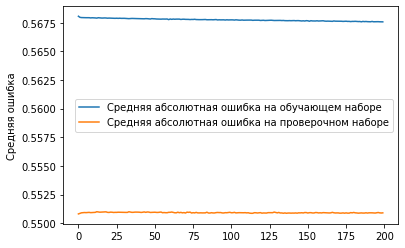

In [104]:
#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

# Готовим столбец CTR

In [105]:
df_train['ctr'].sort_values()

document_id
628cc86b9a79474d02d8b940xnJxG9v0SPygtrcxHx9MUA     0.000
6209266d9a7947267d22e819KMGtFECWQumwEN0ewZx2_A     0.000
61ff6a719a794709da4133c3B0ss8SjSRfa5LxHtciMXqw     0.000
62386e319a7947621669b445fgshRcjKSnanZxhgsO5d4Q     0.000
628f7e7a9a7947c1bb6c80b3aBmKqj9nR6-p-yltvkE5Pg     0.000
                                                   ...  
623c86669a79475a8c852d220PGJl0Z7R-WPMkd66zV7-A    18.771
62889f899a79471f2e5f633aIIClcfBIQBWfSqiNrT8Mpw    19.953
6207ec389a7947de34486e9fJngsbvnSQhywFHQtJ5_dqw    20.990
627a88cf9a794743f350b797rqkVJ5DxRMSUQ-Pj95Q4pQ    22.302
623d82d29a79474e326594ffTcc_fQf3S5KhFDSwStipLA    39.877
Name: ctr, Length: 7000, dtype: float64

In [107]:
# Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.
yTrain_ctr = np.array(df_train['ctr']).reshape(-1, 1)    
yTrain_ctr.shape

(7000, 1)

In [108]:
yCtrScaler = MinMaxScaler()  

yCtrScaler.fit(yTrain_ctr)       # Тренируем нормировщик

yTrain_ctr_Scalered = yCtrScaler.transform(yTrain_ctr)     # Переводим данные в нормированную форму с помощью нормировщика

In [109]:
yTrain_ctr_Scalered.shape

(7000, 1)